# Mathematical model of BERN



## (1) Loading the database

In [2]:
import bern, numpy as np
from matplotlib import pyplot as plt
site_type = bern.load_variables('../BERNdata/site_type.tsv')
print('Possible site variables: ', ', '.join(str(t) for t in site_type), 'in bern', bern.__version__)
pH, BS, CN, WI, CI, VP, T, CWB = site_type

Possible site variables:  pH, BS, CN, WI, CI, VP, T, CWB in bern 0.1.5


In [3]:
db = bern.Database()
print('Species:', db.load_species('../BERNdata/plant-species.tsv'))
print('Communities:', db.load_communities('../BERNdata/communities.tsv'))
db.link_communities('../BERNdata/link_plantspecies_to_community.tsv')

Species: 2210
Communities: 887


9697

In [3]:
# Load forest communities
communities = [
    community
    for community in db.communities()
    if len(community.species) and 2000< community.id < 3000
]
print(len(communities),'Communities with id`s between 2000 and 3000 ')
[c for c in communities if 'Luzulo' in c.name]

374 Communities with id`s between 2000 and 3000 


[Community(2015:"Luzulo luzuloides-Fagetum sylvatici (typ. Subass.) MEUSEL 1937"),
 Community(2016:"Luzulo-Fagetum sylvatici (Carex brizoides-Subass.) MEUSEL 1937"),
 Community(2017:"Luzulo-Fagetum sylvatici (Convallaria majalis-Subass.) MEUSEL 1937"),
 Community(2018:"Luzulo-Fagetum sylvatici (Athyrium filix-femina-Subass.) MEUSEL 1937"),
 Community(2021:"Luzulo-Abieto-Fagetum sylvatici (typ. Subass.) HARTM. et JAHN 1967"),
 Community(2022:"Luzulo-Abieto-Fagetum sylvatici (Vaccinio myrtillus-Subass.) HARTM. et JAHN 1967"),
 Community(2023:"Luzulo-Abieto-Fagetum sylvatici (Dryopteris-Subass.) HARTM. et JAHN 1967"),
 Community(2418:"Luzulo-Abietetum (typ. Subass.) OBERD. 1957"),
 Community(2419:"Luzulo-Abietetum (Athyrium-Subass.) OBERD. 1957"),
 Community(2659:"Luzulo luzuloides-Tilietum cordatae GRABHERR et MUCINA 1989"),
 Community(2679:"Luzulo luzuloides-Piceetum (SCHMID & GAISB. 1936) BR.-BL. & SISSINGH 1939")]

## (2) The niche of a species

Plant species adopt to different environmental traits - nutrient supply, acidity, drought, chill etc. In BERN, we model the potential niche of a plant species as a fuzzy relation between environmental conditions and the plant species using the "Theory of Possibility" (Zadeh 1978). Optimal conditions for a plant species along an environmental gradient is defined as a range (min/max) where plant growth and reproduction is not hampered by the factor. The upper and lower boundary of the optimum conditions are denoted in the following as $x_{max}^+$, $x_{min}^+$, where $x$ is the considered environmental factor. The total range of possible existence is larger (a super set of the optimal conditions) and extends to the pessimum conditions. The plant species should not occur outside of the pessimum conditions. The total range of existence is labelled with $x_{max}^-$, $x_{min}^-$ accordingly.
The existence possibility distribution of the potential niche along an environmental gradient is described with a trapezoid function: 

$$\pi(x)=1 \forall x\in [x_{min}^+..x_{max}^+ ] $$
and
$$\pi(x)=0 \forall x < x_{min}^- \ and\ x>x_{max}^- $$

For the other areas a linear interpolation is used

For the rising limb $ x \in [x_{min}^-..x_{min}^+ ]$

$$ \pi(x) = \frac{x-x_{min}^-}{x_{min}^+ - x_{min}^-} $$

and for the falling limb $x∈[x_{max}^+..x_{max}^- ]$

$$ \pi(x) = \frac{x_{max}^- - x}{x_{max}^- - x_{max}^+} $$

is used.

min:pH: 3.8	BS: 13	CN: 9	WI: 5.4	CI: 8	VP: 95	T: 7.8	CWB: -41	
max:pH: 6.8	BS: 80	CN: 29	WI: 23	CI: 28	VP: 214	T: 30	CWB: 59	


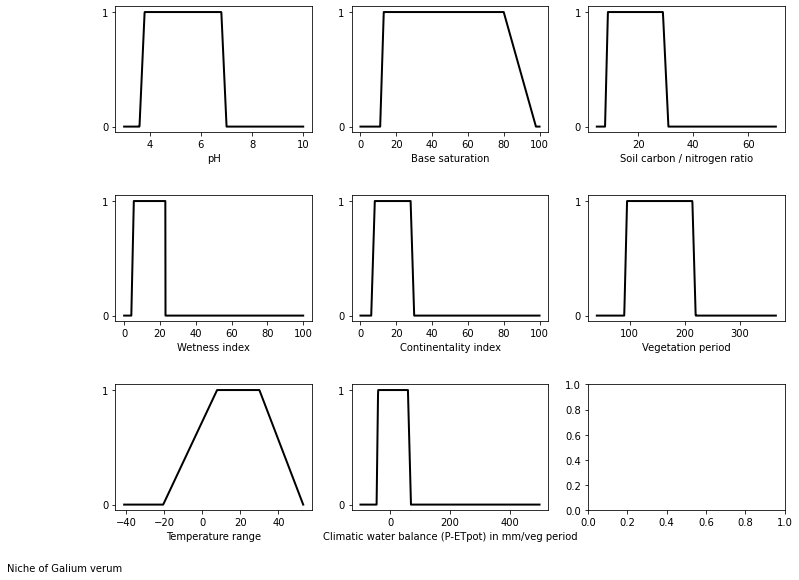

In [11]:

def niche(species, svt):
    opt=species.opt.center()
    ax = np.linspace(svt.min, svt.max, 1001)
    def get_poss(v: float):
        opt=species.opt.center()
        opt[svt.id] = v
        return species.possibility(opt)
    return ax, np.vectorize(get_poss)(ax)

def plot_niche(ax, species, svt):
    x, y = niche(species, svt)
    ax.plot(x, y, 'k-', lw=2)
    ax.set_xlabel(svt.LongName)
    ax.set_yticks([0,1])

def plot_niches(fig, axes, species):
    plt.subplots_adjust(hspace=0.5, top=1.0)
    for svt, ax in zip(site_type, np.ravel(axes)):
        plot_niche(ax, species, svt)
    fig.text(0.0, 0.02, f'Niche of {species.name}')
fig, axes = plt.subplots(nrows=(len(site_type) // 3 + 1), ncols=3, figsize=(12, 8))
print(db.species(226).opt)
plot_niches(fig, axes, db.species(226))

### Combining multiple traits

The possibility $\pi(S, x)$ of a species $S$ to exist at environmental conditions described by the vector 
$x = [pH, BS, CN, wetness, ...]$ is calculated with a Fuzzy-AND operator, since the environmental traits overlap each other. A simple and effective AND operator is to use the minimum of the individual factors:

$$ \pi(S, x) = \min\left(\pi(S, pH), \pi(S, BS), \pi(S, CN), \pi(S, wetness), ...\right) $$

The use of the Fuzzy AND operator reflects the application of Liebig's minimum law.

## (3) The community with its species

A plant community in BERN is defined as group of plant species known to grow together at certain environmental conditions. The possibility of a plant community to exist on a certain site is determined by the overlapping possibilities of each member species of that community. Since the community's internal mechanisms can add to the concurrence strength of its members, BERN creates the overall possibility not as the global minimum of all plant species but with a so called \\(\gamma\\)-Operator from Fuzzy Logic [(Zimmermann, 2010)](https://doi.org/10.1002/wics.82):

$$ \pi_{comm}(x) = \left(\prod_{i=1}^{n} \pi(S_i, x)\right)^\gamma \cdot \left(1-\prod_{i=1}^{n}\left(1-\pi(S_i, x)\right)\right)^{1-\gamma} $$

- $\pi(S_i, x)$ is the possibility value of species $S_i$ at environmental conditions $x = [pH, BS, CN, ...]$.
- $n$ is the number of steady species in the community and $\gamma$ a parameter describing the "community" effect. For the BERN model, we fixed that parameter to 0.2.



### Example: Luzulum-Fageto

The Luzulum-Fageto community is a beech forest community adopted to dry and acidic poor soils and used as an example to show the composition of a community's niche from the potential niches of its species.

Community(2016:"Luzulo-Fagetum sylvatici (Carex brizoides-Subass.) MEUSEL 1937")
Optimum:  p = 1.000000 @ pH: 4.500000	BS: 21.500000	CN: 22.500000	WI: 36.500000	CI: 20.000000	VP: 137.500000	T: 16.600000	CWB: 21.000000	

Species:
Carex brizoides (3043)
Fagus sylvatica (123)
Luzula luzuloides (511)
Milium effusum (167)
Polytrichum formosum (174)
Prenanthes purpurea (445)


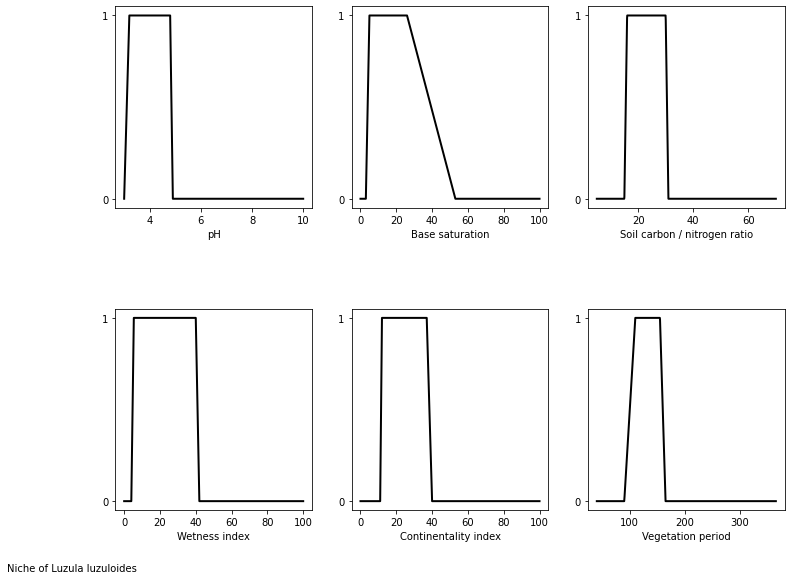

In [5]:
lufag = db.community(2016)
print(lufag)
print('Optimum: ', lufag.optimum())
print('Species:')
for spec in lufag.species:
    print(f'{spec.name} ({spec.id})')
fig, axes = plt.subplots(nrows=(len(site_type) // 3), ncols=3, figsize=(12, 8))
plot_niches(fig, axes, db.species(511))

In [6]:
def plot_community(comm, svt):
    x = np.linspace(svt.min, svt.max, 1001)
    fig, ax = plt.subplots(ncols=1, figsize=(12,8))
    fig.subplots_adjust(bottom=0.5, top=1.0)
    opt = comm.optimum()
    site = bern.SiteVector(opt.site)
    def poss_line(x, obj):
        res = []
        for v in x:
            site[svt.id] = v
            res.append(obj.possibility(site))
        return res
    
    for spec in comm.species:
        ax.plot(x, poss_line(x, spec), label=f'{spec.name} ({spec.id})', lw=1)
    ax.grid()
    ax.set_xlabel(svt.LongName)
    ax.set_ylabel(r'$\pi$')
    ax.plot(x, poss_line(x, comm), label=comm.name, lw=2, ls='--', c='k')
    ax.legend(loc='upper left', bbox_to_anchor=(0.0,-0.2), ncol=3)

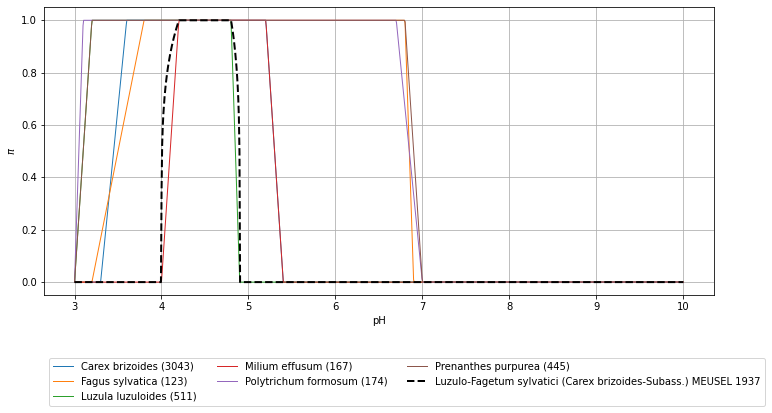

In [7]:
plot_community(lufag, pH)